CT Reconstruction (ADMM Plug-and-Play Priors w/ BM3D, SVMBIR+Prox)
==================================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.optimize.rst#scico.optimize.ADMM) to
solve a tomographic reconstruction problem using the Plug-and-Play Priors
framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser and SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

This version uses the data fidelity term as one of the ADMM $g$
functionals so that the optimization with respect to the data fidelity is
able to exploit the internal prox of the `SVMBIRExtendedLoss` and
`SVMBIRSquaredL2Loss` functionals.

We solve the problem in two different ways:
1. Using the `SVMBIRSquaredL2Loss` together with the BM3D pseudo-functional
   and a non-negative indicator function, and
2. Using the `SVMBIRExtendedLoss`, which includes a non-negativity
   constraint, together with the BM3D pseudo-functional.

In [1]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from matplotlib.ticker import MaxNLocator
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.functional import BM3D, NonNegativeIndicator
from scico.linop import Diagonal, Identity
from scico.linop.radon_svmbir import (
    SVMBIRExtendedLoss,
    SVMBIRSquaredL2Loss,
    TomographicProjector,
)
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, endpoint=False, dtype=snp.float32)
A = TomographicProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Push arrays to device.

In [6]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

Set problem parameters and BM3D pseudo-functional.

In [7]:
ρ = 10  # ADMM penalty parameter
σ = density * 0.26  # denoiser sigma
g0 = σ * ρ * BM3D()

Set up problem using `SVMBIRSquaredL2Loss` and `NonNegativeIndicator`.

In [8]:
f_l2loss = SVMBIRSquaredL2Loss(
    y=y, A=A, W=Diagonal(weights), scale=0.5, prox_kwargs={"maxiter": 5, "ctol": 0.0}
)
g1 = NonNegativeIndicator()

solver_l2loss = ADMM(
    f=None,
    g_list=[f_l2loss, g0, g1],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

Run the ADMM solver.

In [9]:
print(f"Solving on {device_info()}\n")
x_l2loss = solver_l2loss.solve()
hist_l2loss = solver_l2loss.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  7.49e+00  5.376e-01  5.376e-01      0  0.000e+00


   1  1.09e+01  3.687e-01  3.230e-01      1  3.914e-09


   2  1.36e+01  2.416e-01  2.149e-01      1  2.948e-09


   3  1.62e+01  1.574e-01  1.828e-01      1  2.062e-09


   4  1.85e+01  1.191e-01  1.368e-01      1  1.428e-09


   5  2.07e+01  1.015e-01  9.361e-02      1  9.301e-10


   6  2.31e+01  8.628e-02  6.382e-02      1  7.268e-10


   7  2.54e+01  6.853e-02  5.023e-02      1  5.300e-10


   8  2.77e+01  5.316e-02  4.417e-02      1  4.720e-10


   9  3.00e+01  4.382e-02  3.741e-02      1  3.861e-10


  10  3.24e+01  3.911e-02  2.978e-02      1  6.845e-10


  11  3.50e+01  3.552e-02  2.385e-02      1  2.238e-10


  12  3.74e+01  3.222e-02  2.105e-02      1  2.261e-10


  13  3.99e+01  2.913e-02  2.009e-02      1  1.831e-10


  14  4.25e+01  2.653e-02  1.791e-02      1  1.690e-10


  15  4.51e+01  2.453e-02  1.610e-02      1  1.716e-10


  16  4.76e+01  2.308e-02  1.490e-02      1  1.545e-10


  17  5.00e+01  2.175e-02  1.413e-02      1  1.455e-10


  18  5.23e+01  2.062e-02  1.367e-02      1  1.388e-10


  19  5.48e+01  1.960e-02  1.338e-02      1  2.603e-10


Set up problem using `SVMBIRExtendedLoss`, without need for `NonNegativeIndicator`.

In [10]:
f_extloss = SVMBIRExtendedLoss(
    y=y,
    A=A,
    W=Diagonal(weights),
    scale=0.5,
    positivity=True,
    prox_kwargs={"maxiter": 5, "ctol": 0.0},
)

solver_extloss = ADMM(
    f=None,
    g_list=[f_extloss, g0],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

Run the ADMM solver.

In [11]:
print()
x_extloss = solver_extloss.solve()
hist_extloss = solver_extloss.itstat_object.history(transpose=True)

Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  2.49e+00  4.720e-01  4.720e-01      0  0.000e+00


   1  4.93e+00  3.471e-01  2.465e-01      1  5.504e-09


   2  7.35e+00  1.690e-01  2.115e-01      1  9.413e-10


   3  9.68e+00  1.023e-01  1.473e-01      1  2.476e-09


   4  1.32e+01  8.589e-02  8.318e-02      1  1.179e-09


   5  1.56e+01  6.648e-02  4.823e-02      1  1.160e-10


   6  1.80e+01  4.636e-02  3.762e-02      1  8.843e-11


   7  2.04e+01  3.439e-02  3.063e-02      1  6.901e-11


   8  2.28e+01  2.914e-02  2.301e-02      1  5.274e-11


   9  2.52e+01  2.595e-02  1.784e-02      1  4.053e-11


  10  2.76e+01  2.278e-02  1.487e-02      1  3.602e-11


  11  3.00e+01  2.051e-02  1.304e-02      1  3.362e-10


  12  3.24e+01  1.883e-02  1.146e-02      1  1.970e-10


  13  3.47e+01  1.758e-02  1.058e-02      1  1.758e-10


  14  3.71e+01  1.644e-02  9.384e-03      1  1.924e-11


  15  3.94e+01  1.568e-02  9.063e-03      1  1.446e-11


  16  4.18e+01  1.498e-02  8.973e-03      1  2.571e-11


  17  4.43e+01  1.420e-02  8.334e-03      1  1.526e-11


  18  4.66e+01  1.370e-02  8.021e-03      1  1.794e-11


  19  4.93e+01  1.304e-02  7.520e-03      1  1.690e-11


Show the recovered images.

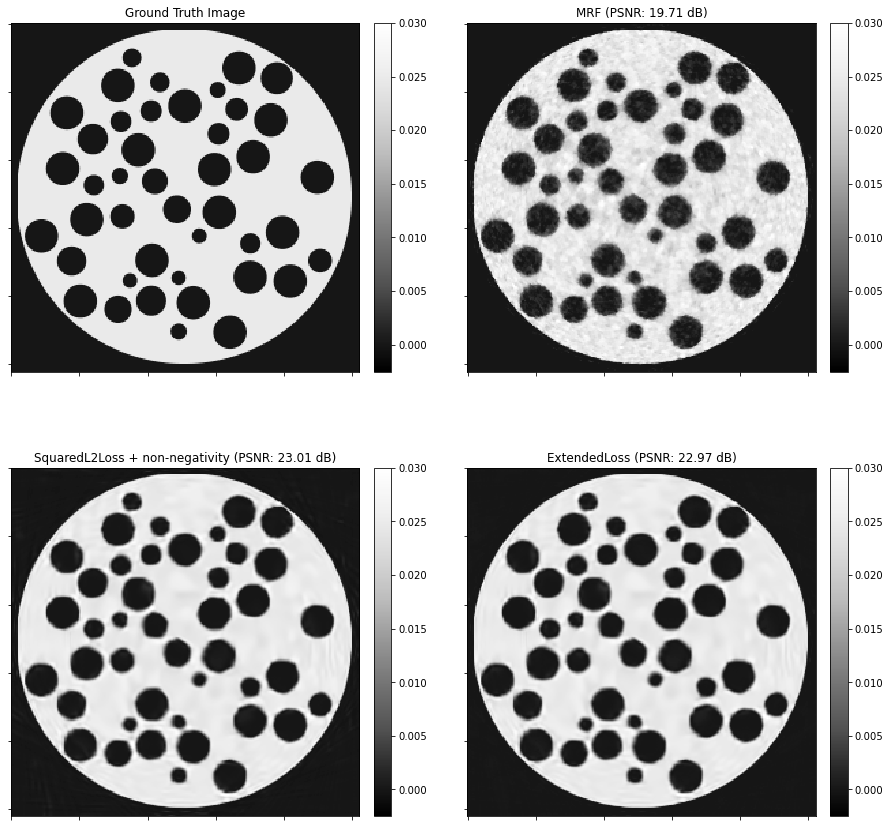

In [12]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[0, 1],
    norm=norm,
)
plot.imview(
    img=x_l2loss,
    title=f"SquaredL2Loss + non-negativity (PSNR: {metric.psnr(x_gt, x_l2loss):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    img=x_extloss,
    title=f"ExtendedLoss (PSNR: {metric.psnr(x_gt, x_extloss):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()

Plot convergence statistics.

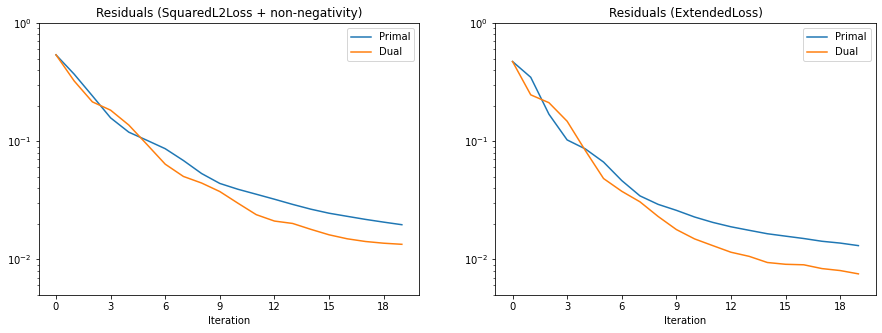

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot.plot(
    snp.vstack((hist_l2loss.Prml_Rsdl, hist_l2loss.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals (SquaredL2Loss + non-negativity)",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[0],
)
ax[0].set_ylim([5e-3, 1e0])
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
plot.plot(
    snp.vstack((hist_extloss.Prml_Rsdl, hist_extloss.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals (ExtendedLoss)",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
ax[1].set_ylim([5e-3, 1e0])
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
fig.show()